# Lesion classification

In [1]:
import sys 
import os
sys.path.append(os.path.abspath("/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/experiment--2"))

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from IPython.display import Image, display

from libs.isic import load
from libs.auc import calculate_auc
from libs.gradcam import display_gradcam, make_gradcam_heatmap, get_img_array

In [3]:
tf.get_logger().setLevel('ERROR')

## Hyperparameter definition

In [4]:
strategy = tf.distribute.MirroredStrategy()

In [5]:
with strategy.scope():
    EPOCHS = 200
    SAMPLE_NUMBER = None
    
    TARGET_WIDTH, TARGET_HEIGHT = 299, 299
    O_MODEL = tf.keras.applications.xception.Xception(
        include_top=False,
        weights='imagenet',
        input_shape=(TARGET_WIDTH, TARGET_HEIGHT, 3),
        pooling='avg'
    )
    RETRAINABLE_LAYERS = []
    LAST_LAYER = 'block14_sepconv2'
    PREPROCESSING = tf.keras.applications.xception.preprocess_input

## Load the ISIC Archive dataset

In [6]:
(training_set, validation_set, testing_set), class_weights, class_number = load(SAMPLE_NUMBER)

/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/experiment--2/libs/isic/load.py:8: DtypeWarning: Columns (3,11,12,14,15,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(f"{os.environ['SCRATCH']}/isic-archive/metadata.csv")


Found 30286 validated image filenames belonging to 10 classes.
Found 7571 validated image filenames belonging to 10 classes.
Found 4207 validated image filenames belonging to 10 classes.


## Model definition

In [7]:
class LesionClassifier(tf.keras.Model):
    def __init__(self):
        super(LesionClassifier, self).__init__()
        
        self.rescale = tf.keras.layers.Rescaling(scale=1. / 255)
        
        self.o_model = O_MODEL
        for layer in self.o_model.layers:
            if layer.name in RETRAINABLE_LAYERS:
                layer.trainable = True
        else:
            layer.trainable = False
        
        self.dense = tf.keras.layers.Dense(class_number, activation='softmax')
        
    def call(self, inputs):
        o_outputs = self.rescale(inputs)
        o_outputs = self.o_model(o_outputs)

        outputs = self.dense(o_outputs)

        return outputs

In [8]:
checkpoint_path = 'checkpoint'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    save_freq='epoch',
    mode='auto'
)

In [9]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    min_delta=0.01, 
    patience=15, 
    restore_best_weights=True
)

In [10]:
time_stopping = tfa.callbacks.TimeStopping(seconds=65 * 3600)

## Training

In [11]:
with strategy.scope():
    model = LesionClassifier()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
model.fit(
    training_set, 
    validation_data=validation_set, 
    epochs=EPOCHS,
    callbacks=[
        checkpoint_callback,
        early_stop_callback,
        time_stopping
    ]
)

Epoch 1/200
947/947 [==============================] - ETA: 0s - loss: 0.7889 - accuracy: 0.7378

947/947 [==============================] - 2541s 3s/step - loss: 0.7889 - accuracy: 0.7378 - val_loss: 0.6887 - val_accuracy: 0.7718
Epoch 2/200
947/947 [==============================] - 2421s 3s/step - loss: 0.6683 - accuracy: 0.7708 - val_loss: 0.7716 - val_accuracy: 0.7665
Epoch 3/200
947/947 [==============================] - ETA: 0s - loss: 0.6212 - accuracy: 0.7829

947/947 [==============================] - 2449s 3s/step - loss: 0.6212 - accuracy: 0.7829 - val_loss: 0.6884 - val_accuracy: 0.7708
Epoch 4/200
947/947 [==============================] - ETA: 0s - loss: 0.5787 - accuracy: 0.7962

947/947 [==============================] - 2447s 3s/step - loss: 0.5787 - accuracy: 0.7962 - val_loss: 0.6765 - val_accuracy: 0.7682
Epoch 5/200
947/947 [==============================] - ETA: 0s - loss: 0.5505 - accuracy: 0.8065

947/947 [==============================] - 2538s 3s/step - loss: 0.5505 - accuracy: 0.8065 - val_loss: 0.5766 - val_accuracy: 0.8008
Epoch 6/200
947/947 [==============================] - ETA: 0s - loss: 0.5277 - accuracy: 0.8136

947/947 [==============================] - 2648s 3s/step - loss: 0.5277 - accuracy: 0.8136 - val_loss: 0.5637 - val_accuracy: 0.8069
Epoch 7/200
947/947 [==============================] - 2480s 3s/step - loss: 0.5059 - accuracy: 0.8213 - val_loss: 0.5935 - val_accuracy: 0.8077
Epoch 8/200
947/947 [==============================] - ETA: 0s - loss: 0.4851 - accuracy: 0.8275

947/947 [==============================] - 2484s 3s/step - loss: 0.4851 - accuracy: 0.8275 - val_loss: 0.4960 - val_accuracy: 0.8255
Epoch 9/200
947/947 [==============================] - 2620s 3s/step - loss: 0.4644 - accuracy: 0.8348 - val_loss: 0.7573 - val_accuracy: 0.7533
Epoch 10/200
947/947 [==============================] - 2917s 3s/step - loss: 0.4514 - accuracy: 0.8398 - val_loss: 0.5203 - val_accuracy: 0.8229
Epoch 11/200
947/947 [==============================] - 2905s 3s/step - loss: 0.4330 - accuracy: 0.8461 - val_loss: 0.5509 - val_accuracy: 0.8094
Epoch 12/200
947/947 [==============================] - ETA: 0s - loss: 0.4126 - accuracy: 0.8535

947/947 [==============================] - 2925s 3s/step - loss: 0.4126 - accuracy: 0.8535 - val_loss: 0.4912 - val_accuracy: 0.8305
Epoch 13/200
947/947 [==============================] - 2924s 3s/step - loss: 0.3979 - accuracy: 0.8555 - val_loss: 0.5535 - val_accuracy: 0.8116
Epoch 14/200
947/947 [==============================] - 2898s 3s/step - loss: 0.3878 - accuracy: 0.8607 - val_loss: 0.4988 - val_accuracy: 0.8264
Epoch 15/200
947/947 [==============================] - ETA: 0s - loss: 0.3739 - accuracy: 0.8670

947/947 [==============================] - 2939s 3s/step - loss: 0.3739 - accuracy: 0.8670 - val_loss: 0.4701 - val_accuracy: 0.8394
Epoch 16/200
947/947 [==============================] - ETA: 0s - loss: 0.3532 - accuracy: 0.8719

947/947 [==============================] - 2625s 3s/step - loss: 0.3532 - accuracy: 0.8719 - val_loss: 0.4333 - val_accuracy: 0.8477
Epoch 17/200
947/947 [==============================] - 2436s 3s/step - loss: 0.3424 - accuracy: 0.8759 - val_loss: 0.4670 - val_accuracy: 0.8420
Epoch 18/200
947/947 [==============================] - 2456s 3s/step - loss: 0.3308 - accuracy: 0.8794 - val_loss: 0.4469 - val_accuracy: 0.8453
Epoch 19/200
947/947 [==============================] - 2431s 3s/step - loss: 0.3177 - accuracy: 0.8850 - val_loss: 0.5364 - val_accuracy: 0.8293
Epoch 20/200
947/947 [==============================] - 2429s 3s/step - loss: 0.3080 - accuracy: 0.8902 - val_loss: 0.4411 - val_accuracy: 0.8470
Epoch 21/200
947/947 [==============================] - 2424s 3s/step - loss: 0.2987 - accuracy: 0.8924 - val_loss: 0.5334 - val_accuracy: 0.8382
Epoch 22/200
947/947 [==============================] - 2411s 3s/step - loss: 0.2793 - accuracy: 0.8972 - val_loss: 0.4768 - val_accuracy

## Testing

In [13]:
model.load_weights(checkpoint_path)

In [14]:
groundtruth_labels = np.concatenate([testing_set[i][1] for i in range(len(testing_set))], axis=0)

In [15]:
predicted_labels = model.predict(testing_set)

132/132 [==============================] - 248s 2s/step


In [16]:
fpr, tpr, auc_metric = calculate_auc(testing_set, groundtruth_labels, predicted_labels)

In [17]:
auc_metric

{'actinic keratosis': 0.9646804443687428,
 'basal cell carcinoma': 0.9854745294195077,
 'dermatofibroma': 0.982813728506478,
 'melanoma': 0.9361625288560949,
 'nevus': 0.9698754709201366,
 'pigmented benign keratosis': 0.9838022999755323,
 'seborrheic keratosis': 0.9569837701765458,
 'solar lentigo': 0.9752802493339366,
 'squamous cell carcinoma': 0.9810091339001504,
 'vascular lesion': 0.9992330066140729}

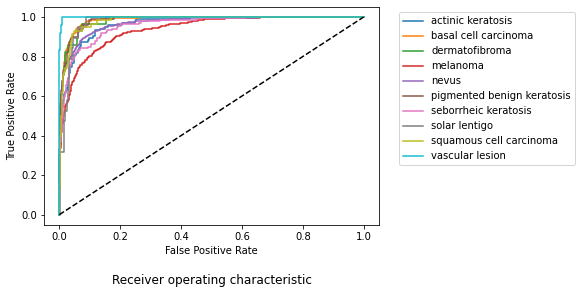

In [18]:
%matplotlib inline 

plt.rcParams['axes.titley'] = -0.3

for diagnosis in testing_set.class_indices:
    plt.plot(fpr[diagnosis], tpr[diagnosis], label=diagnosis)
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(bbox_to_anchor=(1.6, 1), loc="upper right")
plt.show()

## GradCam

In [19]:
melanoma_im_path = f"{os.environ['SCRATCH']}/isic-archive/ISIC_0000031.jpg"

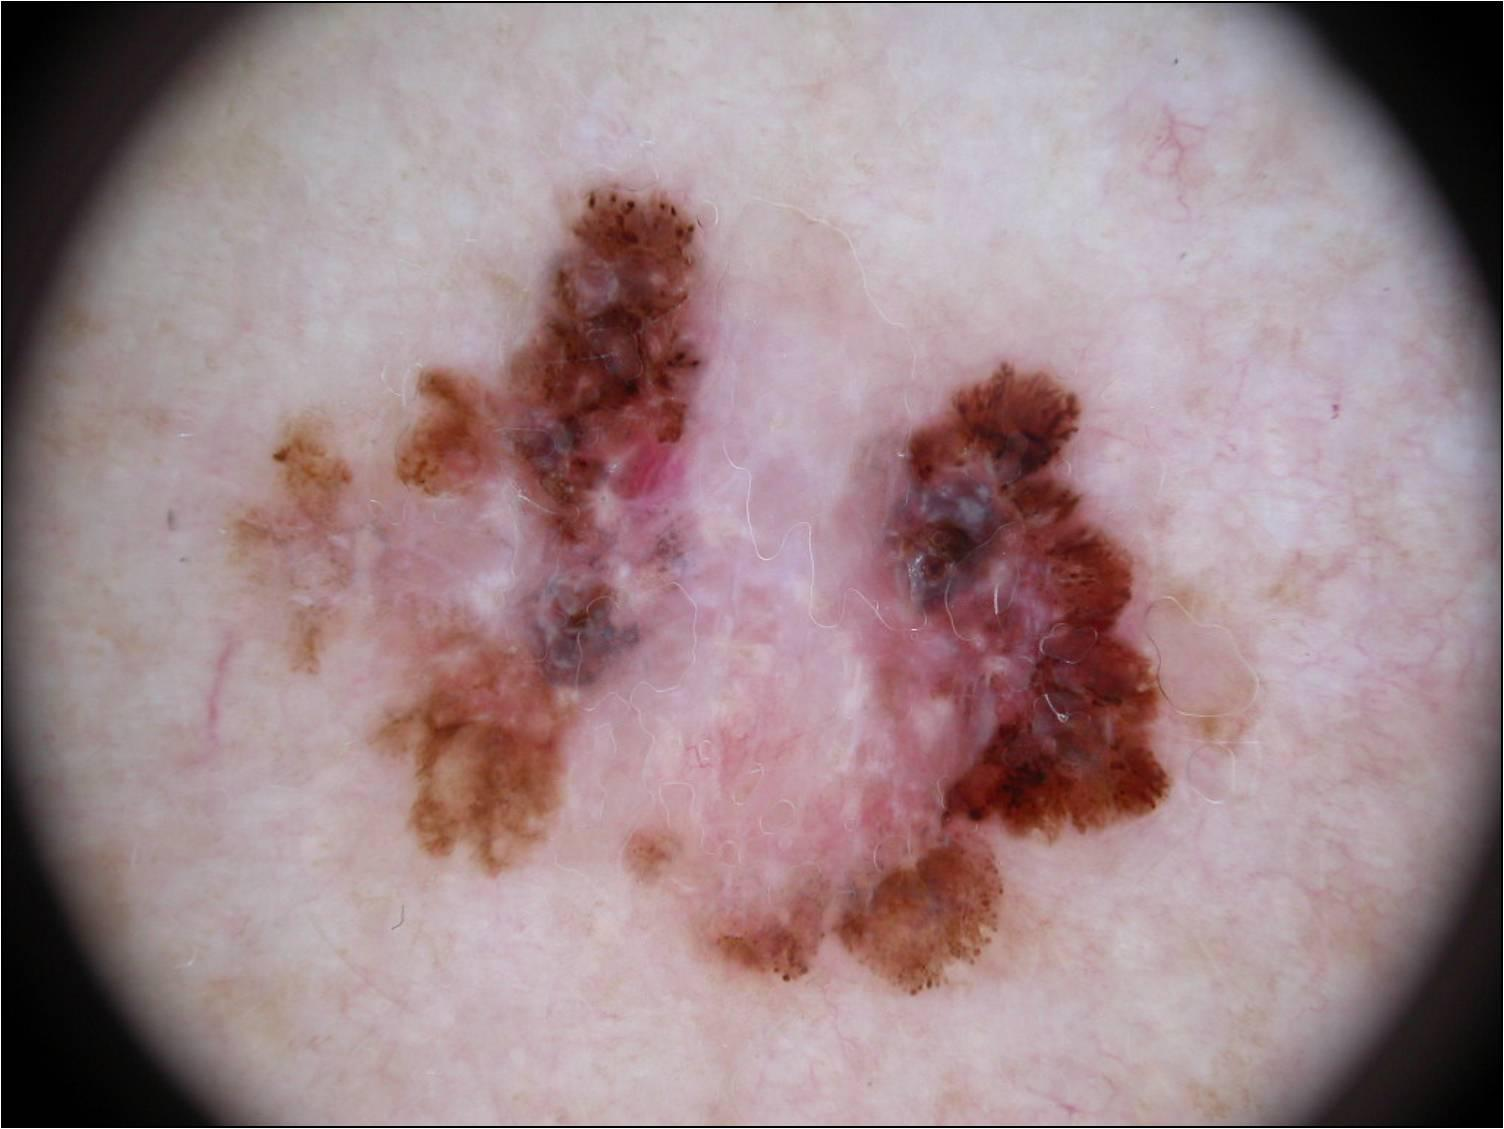

In [20]:
display(Image(melanoma_im_path, width=600))

In [21]:
img_array = PREPROCESSING(get_img_array(melanoma_im_path, size=(299, 299)))

In [22]:
heatmap = make_gradcam_heatmap(img_array, model.o_model, LAST_LAYER)

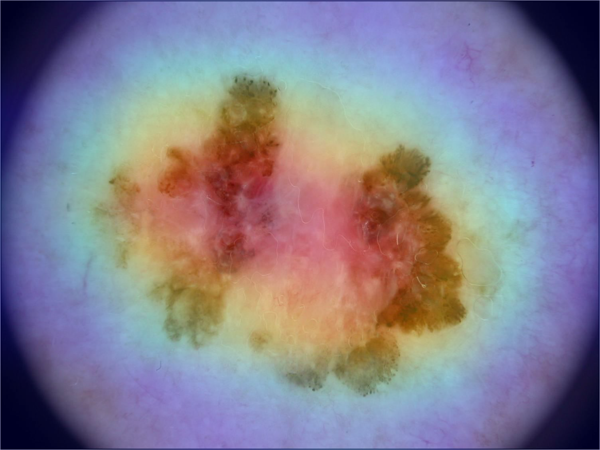

In [23]:
display_gradcam(melanoma_im_path, heatmap)